In [ ]:
!pip install scikit-learn lime matplotlib pandas numpy --quiet

In [ ]:
import io, zipfile
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import files

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from lime.lime_tabular import LimeTabularExplainer

# 1. Configuração e Dependências

**O que foi feito:**

Importação de bibliotecas essenciais (numpy, pandas, matplotlib, scikit-learn, lime) e utilitários do Colab.

Definição de parâmetros visuais e criação da pasta outputs/ para armazenar imagens e arquivos gerados.

Dessa forma mantém o ambiente minimalista e reprodutível, pronto para execução no Colab ou localmente.

In [ ]:
def load_german():
    candidates = [
        Path("german.data"),
        Path("german.data-numeric"),
        Path("/content/german.data"),
        Path("/content/german.data-numeric"),
    ]
    for p in candidates:
        if p.exists():
            return _read_known_file(p, bytes_buf=None)

    print("📤 Não encontrei o dataset localmente. Envie 'german.data', 'german.data-numeric' ou o .zip oficial.")
    uploaded = files.upload()
    for name, raw in uploaded.items():
        p = Path(name)
        if p.suffix.lower() == ".zip":
            with zipfile.ZipFile(io.BytesIO(raw)) as z:
                z.extractall("/content/")
            return load_german()
        if p.name in ("german.data", "german.data-numeric"):
            return _read_known_file(p, bytes_buf=raw)
        if p.suffix.lower() in (".csv", ".txt"):
            for enc in ["utf-8", "utf-8-sig", "latin1", "cp1252"]:
                try:
                    df = pd.read_csv(io.BytesIO(raw), encoding=enc, sep=None, engine="python")
                    print(f"✔️ Lido '{name}' como CSV/TXT (encoding={enc})")
                    return df, name
                except UnicodeDecodeError:
                    continue
    raise FileNotFoundError("Nenhum arquivo válido foi enviado.")

def _read_known_file(path_obj, bytes_buf):
    name = path_obj.name
    if name == "german.data":
        src = io.BytesIO(bytes_buf) if bytes_buf is not None else str(path_obj)
        df = pd.read_csv(src, sep=r"\s+", header=None, engine="python")
        df.columns = [f"A{i}" for i in range(1,21)] + ["target"]
        print(f"✔️ Carregado '{name}' (categórico) — shape {df.shape}")
        return df, name
    elif name == "german.data-numeric":
        src = io.BytesIO(bytes_buf) if bytes_buf is not None else str(path_obj)
        df = pd.read_csv(src, sep=r"\s+", header=None, engine="python")
        df.columns = [f"X{i}" for i in range(1,25)]
        df.rename(columns={df.columns[-1]: "target"}, inplace=True)
        print(f"✔️ Carregado '{name}' (numérico) — shape {df.shape}")
        return df, name
    else:
        raise ValueError("Arquivo não reconhecido.")

df, origem = load_german()

if "target" in df.columns:
    y = (df["target"] == 1).astype(int)
    X = df.drop(columns="target")
else:
    raise ValueError("Coluna 'target' não encontrada após a leitura.")

print("🔎 Origem:", origem)
print("🔢 X shape:", X.shape, "| y shape:", y.shape)
df.head()


✔️ Carregado 'german.data' (categórico) — shape (1000, 21)
🔎 Origem: german.data
🔢 X shape: (1000, 20) | y shape: (1000,)


,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16,A17,A18,A19,A20,target
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,2,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,3,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,4,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,4,A124,53,A143,A153,2,A173,2,A191,A201,2


## 2. Ingestão de dados (UCI – German Credit)

**O que foi feito:**

- Função load_german() faz upload/leitura direta de german.data (categórico) ou german.data-numeric (numérico).

- Tratamento automático de .zip da UCI (extração e leitura).

- Padronização de colunas após a leitura (nomeação dos campos).

A base UCI tem duas variantes. Unificamos o ponto de entrada para aceitar ambas sem ajustes manuais.

##5. Avaliação: acurácia e matriz de confusão

**O que foi feito:**

- Cálculo de acurácia e geração da matriz de confusão (exibição e versão salva em outputs/matriz_confusao.png, se habilitado).

- Acurácia comunica resultado rapidamente; a matriz de confusão revela erros por classe (falsos positivos/negativos), útil para calibragem de política.

✔️ Carregado 'german.data' (categórico) — shape (1000, 21)

📊 Acurácia do modelo: 67.50%

Relatório de classificação:
               precision    recall  f1-score   support

      Negado       0.44      0.33      0.38        60
    Aprovado       0.74      0.82      0.78       140

    accuracy                           0.68       200
   macro avg       0.59      0.58      0.58       200
weighted avg       0.65      0.68      0.66       200



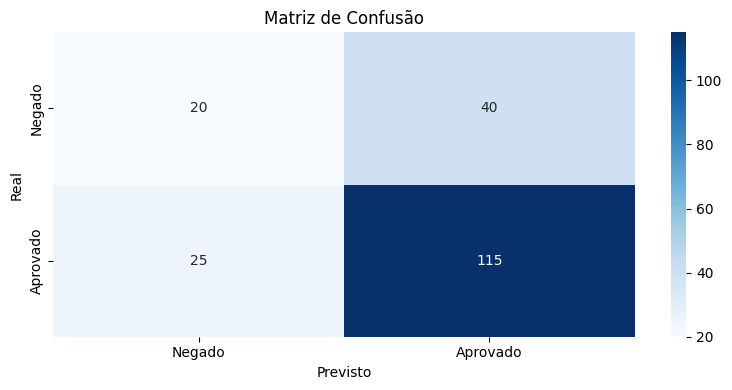

In [ ]:
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

df, _ = load_german()
df = adaptar_para_seis_features(df)


expected_cols = {
    "Renda_Mensal",
    "Score_Credito",
    "Endividamento_%",
    "Tempo_Emprego",
    "Historico_Inadimplencia",
    "Valor_vs_Renda",
    "Aprovado",
}

faltantes = [c for c in ["Renda_Mensal","Score_Credito","Endividamento_%","Tempo_Emprego","Historico_Inadimplencia","Aprovado"] if c not in df.columns]
if faltantes:
    raise ValueError(f"Colunas obrigatórias ausentes no df: {faltantes}")

if "Valor_vs_Renda" not in df.columns:
    if "Valor_Solicitado" in df.columns:
        df["Valor_vs_Renda"] = df["Valor_Solicitado"] / df["Renda_Mensal"].replace(0, np.nan)
    else:
        df["Valor_vs_Renda"] = 1.0

def to_bin(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip().lower()
    return 1 if s in {"1","sim","true","t","yes","y"} else 0

df["Aprovado"] = df["Aprovado"].astype(int)
if not set(df["Aprovado"].unique()).issubset({0,1}):
    raise ValueError("A coluna 'Aprovado' deve ser binária (0/1).")


features = ["Renda_Mensal", "Score_Credito", "Endividamento_%",
            "Tempo_Emprego", "Historico_Inadimplencia", "Valor_vs_Renda"]
target = "Aprovado"

X = df[features].copy()
y = df[target].copy()

if y.nunique() < 2:
    raise ValueError("O alvo possui apenas uma classe. Adicione exemplos das duas classes (0 e 1).")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

pipeline = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=42))
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"\n📊 Acurácia do modelo: {acc*100:.2f}%")
print("\nRelatório de classificação:\n", classification_report(y_test, y_pred, target_names=["Negado","Aprovado"]))


cm = confusion_matrix(y_test, y_pred, labels=[0,1])

plt.figure(figsize=(8,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Negado","Aprovado"],
            yticklabels=["Negado","Aprovado"])
plt.title("Matriz de Confusão")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

##3.Engenharia de atributos

**O que foi feito:**

Função adaptar_para_seis_features(df) converte a base UCI para 6 atributos canônicos e a variável-alvo Aprovado:

- Renda_Mensal – aproximação com base em valor/duração/parcela quando necessário.

- Score_Credito – proxy escalonado (0–1000) combinando status, poupança, histórico e tempo de emprego.

-  Endividamento_% – percentual estimado de comprometimento.

- Tempo_Emprego – mapeado para meses a partir das faixas UCI.

- Historico_Inadimplencia – indicador binário (0/1).

- Valor_vs_Renda – valor solicitado dividido por renda (grau de esforço).

Conversões, mappings e fallbacks garantem valores numéricos válidos e coerentes. Assim são variáveis com semântica de risco claras para o negócio e interpretáveis pelo LIME.

A padronização permite treinar e explicar sempre no mesmo espaço de atributos, independentemente da variante da UCI.

##4. Particionamento, pipeline e treino do modelo

**O que foi feito:**

- train_test_split com estratificação da classe (test_size=0.2, random_state=42).

- Pipeline: StandardScaler → RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=42).

- Treino com pipeline.fit(X_train, y_train).

Random Forest é robusto em dados tabulares e lida bem com relações não lineares.

O StandardScaler padroniza magnitudes e o class_weight='balanced' ajuda em possíveis desbalanceamentos.

In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from lime.lime_tabular import LimeTabularExplainer

import warnings
warnings.filterwarnings(
    "ignore",
    message="X does not have valid feature names, but StandardScaler was fitted with feature names",
    category=UserWarning
)

expected_features = list(X_train.columns)

explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=expected_features,
    class_names=["Negado","Aprovado"],
    discretize_continuous=True,
    mode="classification",
)

def montar_entrada(duracao_meses, valor_credito, idade, taxa_parcela_pct, score):
    row = {
        "duracao_meses": duracao_meses,
        "valor_credito": valor_credito,
        "idade": idade,
        "taxa_parcela_pct": taxa_parcela_pct,
        "score": score,
    }
    return pd.DataFrame([row], columns=expected_features)

def atualizar(_=None):

    entrada_df = montar_entrada(s_tempo.value, s_valor.value, s_idade_widget.value,
                                s_endiv.value, s_score.value)

    pred  = int(pipeline.predict(entrada_df)[0])
    proba = pipeline.predict_proba(entrada_df)[0]

    with out:
        out.clear_output(wait=True)
        print(f"✅ Aprovado: {'✅ Aprovado' if pred==1 else '❌ Negado'} "
              f"| P(Aprovado)={proba[1]:.2f} | P(Negado)={proba[0]:.2f}")

        exp = explainer.explain_instance(
            data_row=entrada_df.values[0],
            predict_fn=pipeline.predict_proba,
            num_features=len(expected_features)
        )
        fig = exp.as_pyplot_figure()
        plt.title("LIME")
        plt.tight_layout()
        plt.show()

s_score = widgets.IntSlider(min=1, max=2, step=1, value=1, description='Score (1=Ruim, 2=Bom)')
s_endiv = widgets.FloatSlider(min=10, max=40, step=10, value=30, description='Taxa Parcela % Renda')
s_tempo = widgets.IntSlider(min=6, max=120, step=1, value=24, description='Duração Crédito (meses)')

s_valor = widgets.FloatSlider(min=500, max=100000, step=500, value=10000, description='Valor Crédito (R$)')
s_idade_widget = widgets.IntSlider(min=18, max=75, step=1, value=30, description='Idade')

out = widgets.Output()


for w in (s_tempo, s_valor, s_idade_widget, s_endiv, s_score):
    w.observe(atualizar, names='value')

display(widgets.VBox([
    widgets.HTML("<h3>Simulador Interativo de Crédito</h3>"),
    s_tempo, s_valor, s_idade_widget, s_endiv, s_score, out
]))

atualizar()


##6. Explicabilidade local com LIME

**O que foi feito:**

Configuração do LimeTabularExplainer com feature_names iguais às 6 variáveis canônicas.

Criação de um wrapper predict_proba_com_nomes(...) que garante que o pipeline receba DataFrames com nomes de colunas (elimina warnings e assegura consistência).

Função prever_e_explicar(...) imprime a decisão e gera o gráfico do LIME (opção de salvar como outputs/lime_*.png).

LIME fornece uma explicação por instância (“quais atributos puxaram para Aprovado/Negado?”), apoiando transparência, auditoria e comunicação.

##7. Simulações de parcelamento e sensibilidade risco × prazo

**O que foi feito:**

PRAZOS configurável (ex.: [6, 12, 18, 24, 36, 48, 60]).

Cenários prontos em EXEMPLOS (aprovado, negado, borderline, premium).

Funções:

simular_parcelas(valor, meses, juros_mensal) – calcula parcela com juros compostos.

montar_entrada(...) – monta o cliente no padrão das 6 variáveis.

tabela_prazos(...) – para cada prazo, calcula parcela, endividamento resultante e P(Aprovado).

Execução automática: para cada cenário, gera previsão + LIME e exibe uma tabela de prazos.

Assim mostra como ajustes de prazo alteram o risco (via endividamento e probabilidade de aprovação), apoiando decisões parametrizadas.

✔️ Dataset: german.data | shape=(1000, 21)
🔧 Features: ['Renda_Mensal', 'Score_Credito', 'Endividamento_%', 'Tempo_Emprego', 'Historico_Inadimplencia', 'Valor_vs_Renda', 'Aprovado']
📊 Acurácia: 0.68
🚀 Rodando cenários de exemplo (sem input):

=== EXEMPLO: APROVADO ===
🧠 Previsto: ✅ Aprovado | P(Aprov.)=0.58 | P(Neg.)=0.42


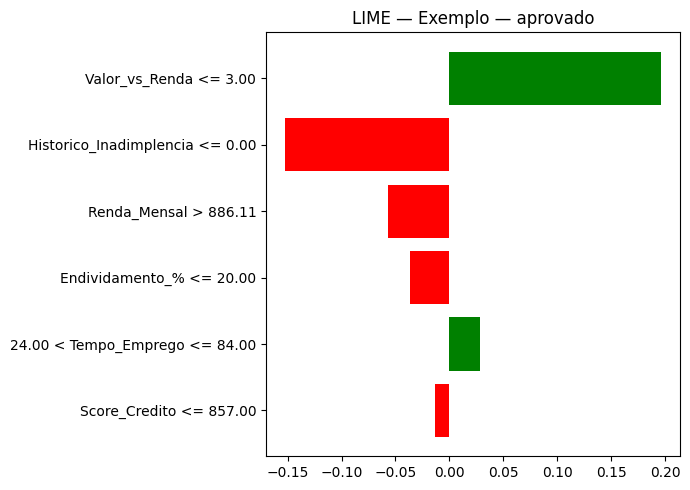

,Prazo (meses),Parcela (R$),Endividamento (%),P(Aprovado),Status
0,6,"R$ 2,677.89",38.3,0.63,Aprovado
1,12,"R$ 1,418.39",20.3,0.58,Aprovado
2,18,"R$ 1,000.53",14.3,0.50,Negado
3,24,R$ 793.07,11.3,0.50,Negado
4,36,R$ 588.49,8.4,0.50,Negado
5,48,R$ 489.03,7.0,0.50,Negado
6,60,R$ 431.52,6.2,0.50,Negado



=== EXEMPLO: NEGADO ===
🧠 Previsto: ✅ Aprovado | P(Aprov.)=0.63 | P(Neg.)=0.37


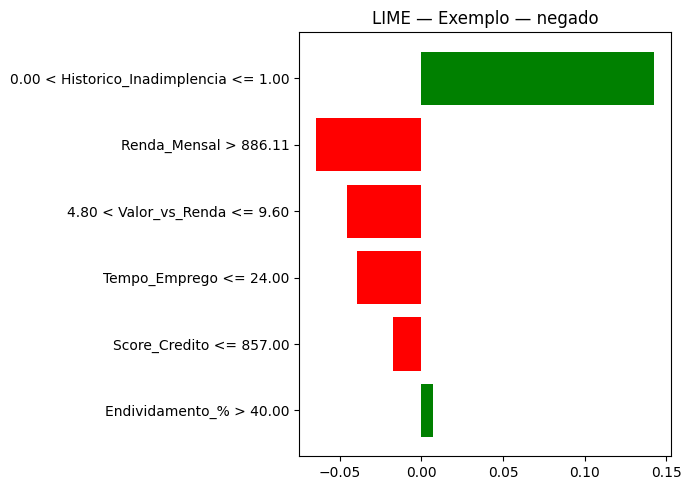

,Prazo (meses),Parcela (R$),Endividamento (%),P(Aprovado),Status
0,6,"R$ 1,606.73",107.1,0.63,Aprovado
1,12,R$ 851.04,56.7,0.63,Aprovado
2,18,R$ 600.32,40.0,0.63,Aprovado
3,24,R$ 475.84,31.7,0.66,Aprovado
4,36,R$ 353.10,23.5,0.68,Aprovado
5,48,R$ 293.42,19.6,0.68,Aprovado
6,60,R$ 258.91,17.3,0.68,Aprovado



=== EXEMPLO: BORDERLINE ===
🧠 Previsto: ✅ Aprovado | P(Aprov.)=0.58 | P(Neg.)=0.42


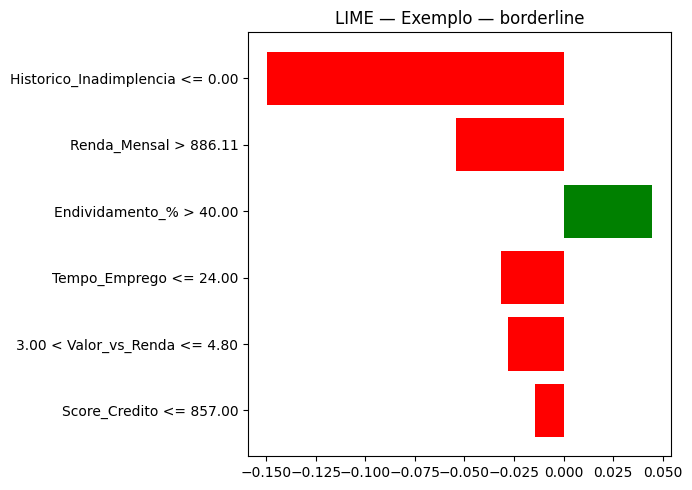

,Prazo (meses),Parcela (R$),Endividamento (%),P(Aprovado),Status
0,6,"R$ 2,142.31",61.2,0.58,Aprovado
1,12,"R$ 1,134.72",32.4,0.55,Aprovado
2,18,R$ 800.43,22.9,0.53,Aprovado
3,24,R$ 634.45,18.1,0.54,Aprovado
4,36,R$ 470.79,13.5,0.53,Aprovado
5,48,R$ 391.22,11.2,0.53,Aprovado
6,60,R$ 345.22,9.9,0.53,Aprovado



=== EXEMPLO: PREMIUM ===
🧠 Previsto: ❌ Negado | P(Aprov.)=0.40 | P(Neg.)=0.60


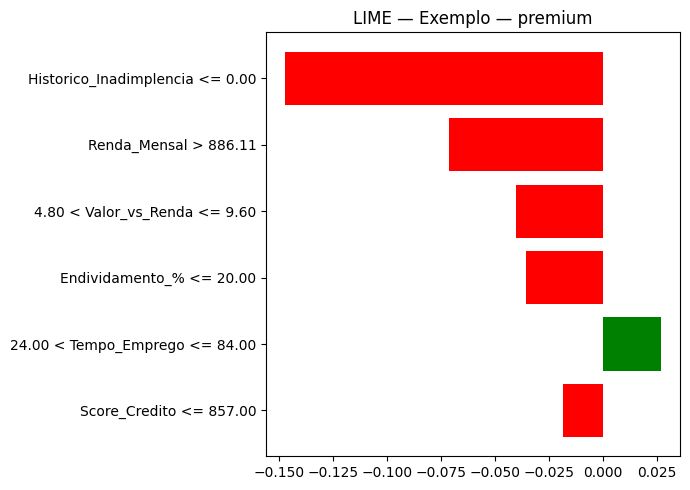

,Prazo (meses),Parcela (R$),Endividamento (%),P(Aprovado),Status
0,6,"R$ 14,282.06",119.0,0.50,Negado
1,12,"R$ 7,564.77",63.0,0.50,Negado
2,18,"R$ 5,336.17",44.5,0.50,Negado
3,24,"R$ 4,229.69",35.2,0.50,Negado
4,36,"R$ 3,138.63",26.2,0.46,Negado
5,48,"R$ 2,608.15",21.7,0.42,Negado
6,60,"R$ 2,301.44",19.2,0.43,Negado



📥 Envie o CSV (com cabeçalhos padrão).


Saving clientes_completo.csv to clientes_completo (7).csv
✔️ Arquivo recebido: clientes_completo (7).csv
✅ Processado. Amostra:
 Renda_Mensal  Score_Credito  Endividamento_%  Tempo_Emprego  Historico_Inadimplencia  Valor_vs_Renda  Valor_Solicitado  Parcelas  Prob_Aprovado Previsto
       2437.0            625               65             19                        0            3.03           7384.19    390.41           0.68 Aprovado
       9626.0            553               55             90                        0            4.41          42492.76   2246.64           0.41   Negado
       8373.0            450               30             84                        0            3.95          33081.12   1749.04           0.36   Negado
       6108.0            859               70             42                        0            2.59          15839.77    837.47           0.65 Aprovado
       6046.0            779               35              8                        0            4.41 

In [ ]:
import io, zipfile, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from google.colab import files
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from lime.lime_tabular import LimeTabularExplainer

plt.rcParams['figure.figsize'] = (7,5)

def load_german():
    for p in [Path("german.data"), Path("german.data-numeric")]:
        if p.exists():
            return p.name, p.read_bytes()
    print("📤 Envie 'german.data' ou 'german.data-numeric' (ou .zip oficial):")
    up = files.upload()
    for name, raw in up.items():
        if name.lower().endswith(".zip"):
            with zipfile.ZipFile(io.BytesIO(raw)) as z:
                z.extractall("/content/")
            for p in [Path("/content/german.data"), Path("/content/german.data-numeric")]:
                if p.exists():
                    return p.name, p.read_bytes()
        else:
            return name, raw
    raise RuntimeError("Arquivo não enviado.")

name, raw = load_german()

if name.endswith("german.data"):
    df = pd.read_csv(io.BytesIO(raw), sep=r"\s+", header=None, engine="python")
    df.columns = [f"A{i}" for i in range(1,21)] + ["target"]
elif name.endswith("german.data-numeric"):
    df = pd.read_csv(io.BytesIO(raw), sep=r"\s+", header=None, engine="python")
    df.columns = [f"X{i}" for i in range(1,25)]
    df.rename(columns={df.columns[-1]:"target"}, inplace=True)
else:
    df = pd.read_csv(io.BytesIO(raw), sep=None, engine="python")

print(f"✔️ Dataset: {name} | shape={df.shape}")

def adaptar_para_seis_features(df_in):
    df = df_in.copy()
    if "A1" in df.columns:
        A1,A2,A3,A5,A6,A7,A8 = "A1","A2","A3","A5","A6","A7","A8"

        endiv_map = {1:10, 2:20, 3:30, 4:40}
        endiv_raw = pd.to_numeric(df[A8], errors="coerce")
        endividamento = endiv_raw.map(endiv_map).fillna(20)

        tempo_map = {"A71":0, "A72":6, "A73":24, "A74":60, "A75":84}
        tempo_emprego = df[A7].map(tempo_map).fillna(12)

        inadimplencia = df[A3].isin(["A33","A34"]).astype(int)

        status_map   = {"A11":300, "A12":600, "A13":750, "A14":500}
        poup_map     = {"A61":  0, "A62": 50, "A63":100, "A64":150, "A65":20}
        hist_bonus   = {"A30":200,"A31":150,"A32":100,"A33":-150,"A34":-200}
        base = 400
        score = (base
                 + df[A1].map(status_map).fillna(500)
                 + df[A6].map(poup_map).fillna(20)
                 + df[A3].map(hist_bonus).fillna(0)
                 + tempo_emprego.clip(0,84) * (200/84.0))
        score = score.clip(300, 950)
        score = ((score - 300) / (950 - 300) * 1000).round().astype(int)

        valor_solicitado = pd.to_numeric(df[A5], errors="coerce")
        duracao = pd.to_numeric(df[A2], errors="coerce").replace(0, np.nan)
        parcela = (valor_solicitado / duracao).replace([np.inf,-np.inf], np.nan)
        renda = (parcela / (endividamento.replace(0,np.nan)/100)).fillna(np.nanmedian(parcela))*1.0

        out = pd.DataFrame({
            "Renda_Mensal": renda.round(2),
            "Score_Credito": score,
            "Endividamento_%": endividamento,
            "Tempo_Emprego": tempo_emprego,
            "Historico_Inadimplencia": inadimplencia,
            "Valor_vs_Renda": (valor_solicitado / renda.replace(0,np.nan)).fillna(0).round(2),
            "Aprovado": (df["target"] == 1).astype(int)
        })
        return out.dropna().reset_index(drop=True)

    elif "X1" in df.columns:
        X = df.copy()
        renda  = (X["X5"]*10 + X["X2"]).clip(800, 20000)
        score  = (700 + (X["X3"] - X["X3"].mean())*5).clip(300, 950).astype(int)
        endiv  = (X["X4"].rank(pct=True)*80 + 10).round(1)
        tempo  = (X["X6"].rank(pct=True)*84).round()
        inad   = (X["X7"]>X["X7"].median()).astype(int)
        valor  = (X["X2"]*10 + 1000).clip(500, 100000)
        out = pd.DataFrame({
            "Renda_Mensal": renda.round(2),
            "Score_Credito": ((score-300)/(950-300)*1000).round().astype(int),
            "Endividamento_%": endiv,
            "Tempo_Emprego": tempo,
            "Historico_Inadimplencia": inad,
            "Valor_vs_Renda": (valor/renda).round(2),
            "Aprovado": (df["target"]==1).astype(int) if "target" in df.columns else 0
        })
        return out
    else:
        raise ValueError("Formato de colunas inesperado.")

df = adaptar_para_seis_features(df)
print("🔧 Features:", list(df.columns))

features = ["Renda_Mensal","Score_Credito","Endividamento_%",
            "Tempo_Emprego","Historico_Inadimplencia","Valor_vs_Renda"]
target   = "Aprovado"

X = df[features].copy()
y = df[target].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

pipeline = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(random_state=42, n_estimators=300, class_weight='balanced')
)
pipeline.fit(X_train, y_train)
print(f"📊 Acurácia: {accuracy_score(y_test, pipeline.predict(X_test)):.2f}")


# ================== LIME + wrappers ==================

expected_features = list(X_train.columns)

def predict_proba_com_nomes(X_in):
    if isinstance(X_in, np.ndarray):
        if X_in.ndim == 1:
            X_in = X_in.reshape(1,-1)
        X_in = pd.DataFrame(X_in, columns=expected_features)
    return pipeline.predict_proba(X_in)

explainer = LimeTabularExplainer(
    training_data=X_train[expected_features].values,
    feature_names=expected_features,
    class_names=["Negado","Aprovado"],
    discretize_continuous=True,
    mode="classification",
)

# ================== SIMULAÇÕES ==================

PRAZOS = [6, 12, 18, 24, 36, 48, 60]
EXEMPLOS = {
    "aprovado":   {"renda": 7000, "score": 780, "endiv": 18, "tempo": 36, "nome_limpo": True,  "valor": 15000},
    "negado":     {"renda": 1500, "score": 420, "endiv": 70, "tempo": 2,  "nome_limpo": False, "valor":  9000},
    "borderline": {"renda": 3500, "score": 640, "endiv": 45, "tempo": 6,  "nome_limpo": True,  "valor": 12000},
    "premium":    {"renda":12000, "score": 820, "endiv": 12, "tempo": 60, "nome_limpo": True,  "valor": 80000},
}

def simular_parcelas(valor, meses, juros_mensal=0.02):
    if meses <= 0: return 0.0
    if juros_mensal == 0: return valor/meses
    return valor * (juros_mensal*(1+juros_mensal)**meses) / ((1+juros_mensal)**meses - 1)

def montar_entrada(renda, score, endiv, tempo_emprego, nome_limpo, valor):
    valor_vs_renda = (valor / renda) if renda > 0 else 0.0
    row = {
        "Renda_Mensal": float(renda),
        "Score_Credito": int(score),
        "Endividamento_%": float(endiv),
        "Tempo_Emprego": int(tempo_emprego),
        "Historico_Inadimplencia": 0 if nome_limpo else 1,
        "Valor_vs_Renda": float(valor_vs_renda),
    }
    return pd.DataFrame([row])[expected_features]

def prever_e_explicar(entrada_df, titulo="Cliente"):
    proba = predict_proba_com_nomes(entrada_df)[0]
    pred  = int(proba[1] >= 0.5)
    print(f"🧠 Previsto: {'✅ Aprovado' if pred==1 else '❌ Negado'} | "
          f"P(Aprov.)={proba[1]:.2f} | P(Neg.)={proba[0]:.2f}")
    exp = explainer.explain_instance(
        data_row=entrada_df.values[0],
        predict_fn=predict_proba_com_nomes,
        num_features=len(expected_features)
    )
    fig = exp.as_pyplot_figure()
    plt.title(f"LIME — {titulo}")
    plt.tight_layout(); plt.show()

def tabela_prazos(renda, score, tempo_emprego, nome_limpo, valor_solicitado):
    linhas = []
    for prazo in PRAZOS:
        parcela = simular_parcelas(valor_solicitado, prazo)
        endiv   = (parcela / renda) * 100 if renda > 0 else 0.0
        entrada = montar_entrada(renda, score, endiv, tempo_emprego, nome_limpo, valor_solicitado)
        proba   = predict_proba_com_nomes(entrada)[0][1]
        status  = "Aprovado" if proba >= 0.5 else "Negado"
        linhas.append([prazo, parcela, endiv, proba, status])
    return pd.DataFrame(linhas, columns=["Prazo (meses)", "Parcela (R$)", "Endividamento (%)", "P(Aprovado)", "Status"])

# ================== EXEMPLOS  # ==================

print("🚀 Rodando cenários de exemplo (sem input):\n")
for nome_ex, ex in EXEMPLOS.items():
    print(f"=== EXEMPLO: {nome_ex.upper()} ===")
    entrada = montar_entrada(ex["renda"], ex["score"], ex["endiv"], ex["tempo"], ex["nome_limpo"], ex["valor"])
    prever_e_explicar(entrada, f"Exemplo — {nome_ex}")
    tab = tabela_prazos(ex["renda"], ex["score"], ex["tempo"], ex["nome_limpo"], ex["valor"])
    display(tab.style.format({"Parcela (R$)": "R$ {:,.2f}", "Endividamento (%)": "{:.1f}", "P(Aprovado)": "{:.2f}"}))
    print()

import io as _io

CSV_PATH = "/content/clientes.csv"

def _read_any_csv(raw_bytes):
    for enc in ("utf-8", "utf-8-sig", "latin1", "cp1252"):
        try:
            return pd.read_csv(_io.BytesIO(raw_bytes), encoding=enc, sep=None, engine="python")
        except Exception:
            pass
    raise RuntimeError("Não foi possível ler o CSV (encodings testados: utf-8, utf-8-sig, latin1, cp1252).")

if Path(CSV_PATH).exists():
    raw_bytes = Path(CSV_PATH).read_bytes()
    print(f"✔️ Lendo: {CSV_PATH}")
else:
    print("📥 Envie o CSV (com cabeçalhos padrão).")
    up = files.upload()
    fname = list(up.keys())[0]
    raw_bytes = up[fname]
    print(f"✔️ Arquivo recebido: {fname}")

df_in = _read_any_csv(raw_bytes)

features_canon = ["Renda_Mensal","Score_Credito","Endividamento_%","Tempo_Emprego","Historico_Inadimplencia","Valor_vs_Renda"]
expected_features = list(X_train.columns) if 'X_train' in globals() else features_canon

if "Valor_vs_Renda" not in df_in.columns and {"Valor_Solicitado","Renda_Mensal"}.issubset(df_in.columns):
    df_in["Valor_vs_Renda"] = (df_in["Valor_Solicitado"]/df_in["Renda_Mensal"]).replace([np.inf,-np.inf], np.nan).fillna(0).round(2)

faltando = [c for c in expected_features if c not in df_in.columns]
if faltando:
    raise ValueError(f"Colunas faltando no CSV: {faltando}\n"
                     f"Use os cabeçalhos: {expected_features} "
                     f"(ou inclua Valor_Solicitado para eu calcular Valor_vs_Renda).")

X_batch = df_in[expected_features].copy()
proba = predict_proba_com_nomes(X_batch)[:,1]
pred  = (proba >= 0.5).astype(int)

saida = df_in.copy()
saida["Prob_Aprovado"] = np.round(proba, 2)
saida["Previsto"] = np.where(pred==1, "Aprovado", "Negado")

out_name = "resultados_clientes.csv"
saida.to_csv(out_name, index=False)
print("✅ Processado. Amostra:")
print(saida.head(10).to_string(index=False))
print(f"💾 Salvo em: {out_name}")
